<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

1. Clean data
    1a. Drop Id column
    1b. Remove data that are unrelated to residential type
    1c. Spilt the dataset into 6 categorical subsets
    1d. Check and modify the value types of the subsets based on their characteristic  
    1e. Replace numeric and ordinal nan to mean /categorical nan to "unknown"
    1f. Convert categorical subsets values to dummy variables
    1g. Combine subsets to either fixed or nonfixed and standardize both sets 
then spilt data to before_2010 and during_2010
Further split them to fixed and non-fixed, then ordinal, categorical, and numerical data
set up models - lasso - link with next step
use cross validation
use t-test on results- can check via results.pvalues from OLS



In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

1a. Drop Id column

In [3]:
house.drop("Id", axis= 1, inplace = True)

1b. Remove data that is unrelated to residential type

In [4]:
residential_zoning = ["FV", "RH", "RL", "RP", "RM"]
df = house.loc[house['MSZoning'].isin(residential_zoning)]

1c. Spilt the dataset into the following 6 categorical subsets

Fixed Categorical:
MSSubClass, MSZoning, Street, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, MasVnrType, Foundation, BsmtQual, BsmtExposure, GarageType, MiscFeature, MoSold

Fixed Numeric:
LotFrontage, LotArea, MasVnrArea, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, Bedroom, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal

Fixed Ordinal:
YearBuilt, GarageYrBlt

Non-fixed Categorical:
Utilities, RoofMatl, Exterior1st, Exterior2nd, BsmtCond, BsmtFinType1, BsmtFinType2, Heating, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageFinish, GarageQual, GarageCond, PavedDrive, Fence, SaleType, ExterQual, ExterCond, HeatingQC

Non-fixed Numeric:
BsmtFinSF2, BsmtUnfSF, LowQualFinSF
	
Non-fixed Ordinal:
OverallQual, OverallCond, YearRemodAdd

In [5]:
fixed_categorical = ["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "MasVnrType", "Foundation", "BsmtQual", "BsmtExposure", "GarageType", "MiscFeature", "MoSold", "YrSold",'SaleCondition']
fixed_numeric = ["LotFrontage", "LotArea", "MasVnrArea", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"]
fixed_ordinal =["YearBuilt", "GarageYrBlt"]
nonfixed_categorical = ["Utilities", "RoofMatl", "Exterior1st", "Exterior2nd", "BsmtCond", "BsmtFinType1", "BsmtFinType2", "Heating", "CentralAir", "Electrical", "KitchenQual", "Functional", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "Fence", "SaleType", "ExterQual", "ExterCond", "HeatingQC"]
nonfixed_numeric = ["BsmtFinSF2", "BsmtUnfSF", "LowQualFinSF"]
nonfixed_ordinal =["OverallQual", "OverallCond", "YearRemodAdd"]

df_fixed_categorical = df[fixed_categorical]
df_fixed_numeric = df[fixed_numeric]
df_fixed_ordinal = df[fixed_ordinal]
df_nonfixed_categorical = df[nonfixed_categorical]
df_nonfixed_numeric = df[nonfixed_numeric]
df_nonfixed_ordinal = df[nonfixed_ordinal]


1d. Check and modify the value types of the subsets based on their characteristic 
Details: categorical -> object/str, numeric -> int/float, ordinal -> int/float


In [6]:
# Inspect the types by uncommenting and running the following statments
# df_fixed_categorical.info()
# df_fixed_numeric.info()
# df_fixed_ordinal.info()
# df_nonfixed_categorical.info()
# df_nonfixed_numeric.info()
# df_nonfixed_ordinal.info()

# based on findings, MSSubClass, YrSold, and MoSold should be in str instead of numeric.
df_fixed_categorical['MSSubClass'] = df_fixed_categorical['MSSubClass'].apply(lambda x: str(x))
df_fixed_categorical['MoSold'] = df_fixed_categorical['MoSold'].apply(lambda x: str(x))
df_fixed_categorical['YrSold'] = df_fixed_categorical['YrSold'].apply(lambda x: str(x))


C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

1e. Replace numeric and ordinal nan to mean /categorical nan to "unknown"

In [7]:
# replacing nan from numeric and ordinal subsets with mean
df_fixed_numeric = df_fixed_numeric.fillna(df_fixed_numeric.mean())
df_fixed_ordinal = df_fixed_ordinal.fillna(df_fixed_ordinal.mean())
df_nonfixed_numeric = df_nonfixed_numeric.fillna(df_nonfixed_numeric.mean())
df_nonfixed_ordinal = df_nonfixed_ordinal.fillna(df_nonfixed_ordinal.mean())

# replacing nan from categorical subsets with 'unknown'
df_fixed_categorical = df_fixed_categorical.fillna("unknown")
df_nonfixed_categorical = df_nonfixed_categorical.fillna("unknown")


1f. convert categorical subsets values to dummy variables

In [8]:
df_fixed_categorical = pd.get_dummies(df_fixed_categorical, drop_first = True) 
df_nonfixed_categorical = pd.get_dummies(df_nonfixed_categorical, drop_first = True)

Combine subsets to either fixed or nonfixed and standardize both sets, then split to pre 2010 and 2010

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_fixed = pd.concat([df_fixed_numeric, df_fixed_ordinal, df_fixed_categorical], axis=1)
df_nonfixed = pd.concat([df_nonfixed_numeric, df_nonfixed_ordinal, df_nonfixed_categorical], axis=1)

df_fixed_pre2010 = df_fixed[df_fixed['YrSold_2010'] == 0]
df_fixed_2010 = df_fixed[df_fixed['YrSold_2010'] == 1]
df_nonfixed_pre2010 = df_nonfixed[df_fixed['YrSold_2010']== 0]
df_nonfixed_2010 = df_nonfixed[df_fixed['YrSold_2010'] == 1]

# for question 1
df_fixed_pre2010[list(df_fixed_pre2010)] = scaler.fit_transform(df_fixed_pre2010[list(df_fixed_pre2010)])
df_fixed_2010[list(df_fixed_2010)] = scaler.fit_transform(df_fixed_2010[list(df_fixed_2010)])
# for question 2
df_nonfixed_pre2010[list(df_nonfixed_pre2010)] = scaler.fit_transform(df_nonfixed_pre2010[list(df_nonfixed_pre2010)])
df_nonfixed_2010[list(df_nonfixed_2010)] = scaler.fit_transform(df_nonfixed_2010[list(df_nonfixed_2010)])

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda2\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

1g. We will be using linear regression + lasso because we didn't remove a single feature voluntarily. So we should let lasso remove as much as possible.
1h. Find lasso alpha optimal.

In [10]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import cross_val_score

Y = df[df['YrSold'] != 2010]['SalePrice']
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(df_fixed_pre2010, Y)

print optimal_lasso.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

580.9976486168202


...........[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.8s finished


1i. Apply the lasso model with cross validations

In [11]:
lasso = Lasso(alpha=optimal_lasso.alpha_, fit_intercept = True)

lasso_scores = cross_val_score(lasso, df_fixed_pre2010, Y, cv=10)
lasso.fit(df_fixed_pre2010, Y)
print lasso_scores
print np.mean(lasso_scores)
lasso_coefs = pd.DataFrame({'variable':df_fixed_pre2010.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print 'Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_))

[0.89709092 0.84780207 0.85695907 0.73611857 0.82990953 0.72137892
 0.87765097 0.81839601 0.53676191 0.85903685]
0.7981104811987627
Percent variables zeroed out: 0.44375


1j. Evaluate the strength of the model using a scatter plot

In [12]:
pred_y = pd.DataFrame(lasso.predict(df_fixed_2010), columns = ['predicted_price']).reset_index(drop=True)
y = pd.DataFrame(df[df['YrSold'] == 2010]['SalePrice']).reset_index(drop=True)

q1_result = pd.concat([y, pred_y], axis=1)



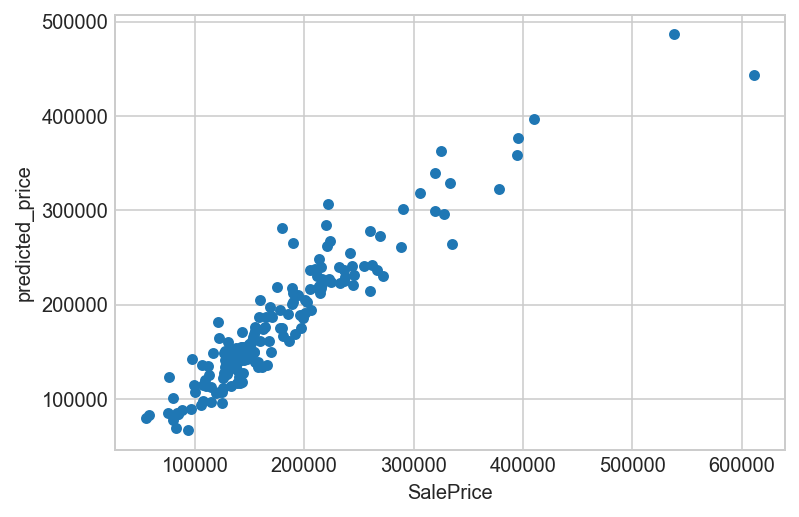

In [13]:
#answer
q1_result.plot(0,1, kind='scatter')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [14]:
# This whole section is dedicated to find all the residuals
pred_y = pd.DataFrame(lasso.predict(df_fixed_pre2010), columns = ['predicted_price']).reset_index(drop=True)
y = pd.DataFrame(df[df['YrSold'] != 2010]['SalePrice']).reset_index(drop=True)

result = pd.concat([y, pred_y], axis=1)

#find and combine both pre2010 and 2010 residuals
residuals = pd.DataFrame(result['SalePrice'] - result['predicted_price'])
residuals_2010 = pd.DataFrame(q1_result['SalePrice'] - q1_result['predicted_price'])
residuals = residuals.append(residuals_2010)
residuals[list(residuals)] = scaler.fit_transform(residuals[list(residuals)])


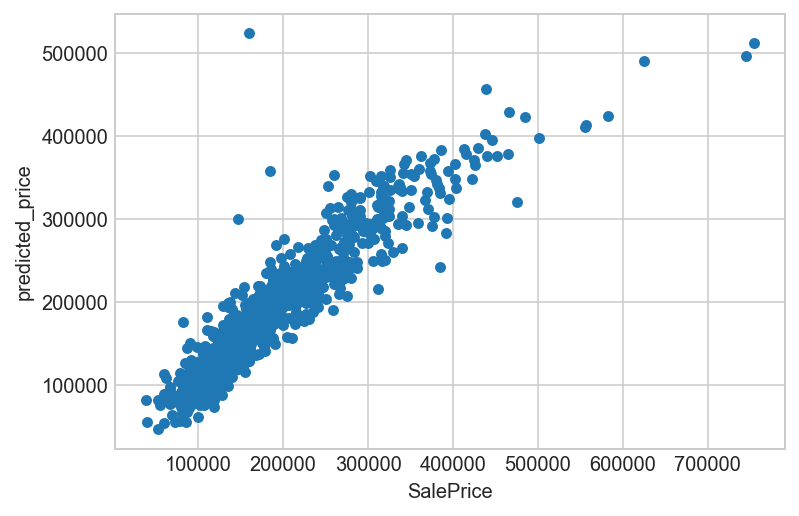

In [15]:
result.plot(0,1, kind='scatter')

2. Simlar to Q1, find optimal alpha, run lasso using nonfixed data

In [16]:
# Find lasso alpha
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(df_nonfixed, residuals)

print optimal_lasso.alpha_

C:\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.012128352260413141


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


In [17]:
lasso = Lasso(alpha=optimal_lasso.alpha_, fit_intercept = True)

lasso_scores = cross_val_score(lasso, df_nonfixed, residuals, cv=10)
lasso.fit(df_nonfixed, residuals)
print lasso_scores
print np.mean(lasso_scores)
lasso_coefs = pd.DataFrame({'variable':df_nonfixed.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print 'Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_))

[-0.03705486 -0.02664619  0.02261874  0.01239982 -0.00986853  0.00098299
 -0.00442637  0.00814332 -0.03140529 -0.01475007]
-0.008000642888155541
Percent variables zeroed out: 0.8934426229508197


In [18]:
lasso_coefs

,abs_coef,coef,variable
71,0.103969,-0.103969,KitchenQual_Gd
35,0.090448,0.090448,Exterior2nd_MetalSd
98,0.087254,-0.087254,PavedDrive_Y
26,0.068272,-0.068272,Exterior1st_Wd Sdng
3,0.029237,0.029237,OverallQual
121,0.015165,-0.015165,HeatingQC_TA
82,0.012430,-0.012430,FireplaceQu_TA
48,0.004283,0.004283,BsmtFinType1_GLQ
4,0.000803,0.000803,OverallCond
0,0.000341,0.000341,BsmtFinSF2


Answer: Non-fixed co-efficients and scores are too insignificant to provide any solid result. The only two noticeable features for improvement are Exterior2nd_MetalSd and OverallQual if you really want to squeeze something out of this analysis. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

3a. Exclude PoolQC, Fence, MiscFeature, Alley because they have to mny null values to be useful

In [19]:
# Check the variables and exclude those that are not useful
house['SaleCondition'].value_counts()
mydf = house[house['SaleCondition'] == 'Abnorml']

3b. Install imblearn to solve the class imbalance issues

In [20]:
!pip install imblearn

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


3c. Similar to Q1, we clean the data before we can use them

In [21]:
categorical = ["Utilities", "RoofMatl", "Exterior1st", "Exterior2nd", "BsmtCond", "BsmtFinType1", "BsmtFinType2", "Heating", "CentralAir", "Electrical", "KitchenQual", "Functional", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "Fence", "SaleType", "ExterQual", "ExterCond", "HeatingQC", "MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "MasVnrType", "Foundation", "BsmtQual", "BsmtExposure", "GarageType", "MiscFeature", "MoSold", "YrSold"]
numeric = ["BsmtFinSF2", "BsmtUnfSF", "LowQualFinSF", "LotFrontage", "LotArea", "MasVnrArea", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"]
ordinal =["YearBuilt", "GarageYrBlt", "OverallQual", "OverallCond", "YearRemodAdd"]

df_q3_categorical = house[categorical]
df_q3_numeric = house[fixed_numeric]
df_q3_ordinal = house[fixed_ordinal]

df_q3_categorical['MSSubClass'] = df_q3_categorical['MSSubClass'].apply(lambda x: str(x))
df_q3_categorical['MoSold'] = df_q3_categorical['MoSold'].apply(lambda x: str(x))
df_q3_categorical['YrSold'] = df_q3_categorical['YrSold'].apply(lambda x: str(x))

# replacing nan from numeric and ordinal subsets with mean
df_q3_numeric = df_q3_numeric.fillna(df_q3_numeric.mean())
df_q3_ordinal = df_q3_ordinal.fillna(df_q3_ordinal.mean())


# replacing nan from categorical subsets with 'unknown'
df_q3_categorical = df_q3_categorical.fillna("unknown")

# replacing cat values with dummy variables
df_q3_categorical = pd.get_dummies(df_q3_categorical, drop_first = True)

#combine all 3 types of subsets into 1
df_q3 = pd.concat([df_q3_numeric, df_q3_ordinal, df_q3_categorical], axis=1)

#spilt dataset into training(pre2010) and testing(2010) subsets
df_q3_pre2010 = df_q3[df_q3['YrSold_2010'] == 0]
df_q3_2010 = df_q3[df_q3['YrSold_2010'] == 1]

# Standardize
df_q3_pre2010[list(df_q3_pre2010)] = scaler.fit_transform(df_q3_pre2010[list(df_q3_pre2010)])
df_q3_2010[list(df_q3_2010)] = scaler.fit_transform(df_q3_2010[list(df_q3_2010)])

# Create y_test(abnormal)
df_q3_abnormal = house[house['YrSold'] != 2010]['SaleCondition']
df_q3_abnormal = df_q3_abnormal.apply(lambda x : 1 if(x == "Abnorml") else 0)


C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

3d. Over sample our training dataset, then feed it to the models, Search for the best model

In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier

# I favor oversampling because we have only 100+ abnormal cases
os = SMOTE(random_state = 2)
X_train_res, y_train_res = os.fit_sample(df_q3_pre2010, df_q3_abnormal )

# Use below to try undersampling
# us = RandomUnderSampler(ratio = 0.5, random_state = 2)
# X_train_res, y_train_res = us.fit_sample(df_q3_pre2010, df_q3_abnormal )

# Test out which model has the best results: elasticnet or lasso; logistic regression or SVM
tuned_parameters = {'alpha': [10 ** a for a in range(-6, 3)], 
                   'penalty': ['elasticnet', 'l2'],
                   'loss': ['hinge', 'log']}
clf = GridSearchCV(SGDClassifier( max_iter=10, shuffle=False, verbose=False, n_jobs=10, average=False, class_weight='balanced'), tuned_parameters, cv=5, scoring='f1_macro')

# Now clf is the best classifier found given the search space
clf.fit(X_train_res, y_train_res)

# Check the propeties of your model
print(clf.best_params_)    
y_test = house[house['YrSold'] == 2010]['SaleCondition']
y_test  = y_test .apply(lambda x : 1 if(x == "Abnorml") else 0)

print classification_report(y_test, clf.predict(df_q3_2010))


C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'penalty': 'elasticnet', 'alpha': 0.001, 'loss': 'hinge'}
             precision    recall  f1-score   support

          0       0.95      0.91      0.93       164
          1       0.17      0.27      0.21        11

avg / total       0.90      0.87      0.88       175



3e. 0.27 recall isn't impressive. We extract the top 15 estimators and run everything again 

In [23]:
for i in range(0, clf.best_estimator_.coef_.shape[0]):
    top15 = np.argsort(clf.best_estimator_.coef_[i])[-15:]
top15

array([ 35,  94, 129, 241, 174,  75,  98, 189, 173,  21, 160, 178, 244,
        79, 245], dtype=int64)

In [24]:
df_top15_pre2010 = df_q3_pre2010.iloc[:, top15]

In [26]:
os = SMOTE(random_state = 2)

X_train_res, y_train_res = os.fit_sample(df_top15_pre2010, df_q3_abnormal )

# us = RandomUnderSampler(ratio = 0.5, random_state = 2)
# X_train_res, y_train_res = us.fit_sample(df_q3_pre2010, df_q3_abnormal )

tuned_parameters = {'alpha': [10 ** a for a in range(-6, 3)], 
                   'penalty': ['elasticnet', 'l2'],
                   'loss': ['hinge', 'log']}
clf = GridSearchCV(SGDClassifier( max_iter=10, shuffle=False, verbose=False, n_jobs=10, average=False, class_weight='balanced'), tuned_parameters, cv=5, scoring='f1_macro')

#now clf is the best classifier found given the search space
clf.fit(X_train_res, y_train_res)

#you can find the best alpha here
print(clf.best_params_)    
y_test = house[house['YrSold'] == 2010]['SaleCondition']
y_test  = y_test.apply(lambda x : 1 if(x == "Abnorml") else 0)
df_top15_2010 = df_q3_2010.iloc[:, top15]

print classification_report(y_test, clf.predict(df_top15_2010))

{'penalty': 'l2', 'alpha': 0.1, 'loss': 'log'}
             precision    recall  f1-score   support

          0       0.95      0.57      0.71       164
          1       0.08      0.55      0.14        11

avg / total       0.89      0.57      0.68       175



3f. The new result looks more promising.

The following are the features you should take note for abnormal sale

In [27]:
df_top15_pre2010.columns

Index([u'Exterior1st_BrkComm', u'Functional_Min1', u'SaleType_Oth',
       u'BsmtQual_TA', u'LandSlope_Sev', u'BsmtFinType2_LwQ',
       u'Functional_Typ', u'Neighborhood_NoRidge', u'LandSlope_Mod',
       u'ScreenPorch', u'Street_Pave', u'Neighborhood_ClearCr',
       u'BsmtExposure_Mn', u'Heating_GasA', u'BsmtExposure_No'],
      dtype='object')